# Decision Tree Pipeline

## Loading Essentials and Helper Functions

In [46]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib
import os
import time
#Sklearn classes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix,silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

from matplotlib import pyplot
import itertools

%matplotlib inline

#Sets random seed
import random 
random.seed(42) 

In [47]:
#Helper functions
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=0)
    plt.yticks(np.arange(num_classes), classes)
    plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True form')
    plt.xlabel('Predicted form')
    plt.gca().xaxis.set_label_position('top')
    plt.tight_layout()
    plt.show()
    
def heatmap(data, row_labels, col_labels, figsize = (20,12), cmap = "YlGn",
            cbar_kw={}, cbarlabel="", valfmt="{x:.2f}",
            textcolors=("black", "white"), threshold=None):
    """
    Create a heatmap from a numpy array and two lists of labels. 
    
    Taken from matplotlib example.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cmap
        A string that specifies the colormap to use. Look at matplotlib docs for information.
        Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
    """

    plt.figure(figsize = figsize)
    ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data,cmap=cmap)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)


def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def draw_contour(x,y,clf, class_labels = ["Negative", "Positive"]):
    """
    Draws a contour line for the predictor
    
    Assumption that x has only two features. This functions only plots the first two columns of x.
    
    """
    
    X0, X1 = x[:, 0], x[:, 1]
    xx0, xx1 = make_meshgrid(X0,X1)
    
    plt.figure(figsize = (10,6))
    plot_contours(clf, xx0, xx1, cmap="PiYG", alpha=0.8)
    scatter=plt.scatter(X0, X1, c=y, cmap="PiYG", s=30, edgecolors="k")
    plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)

    plt.xlim(xx0.min(), xx0.max())
    plt.ylim(xx1.min(), xx1.max())
    


### Bicep Curls Data Processing

In [ ]:
#Preprocess Data

#Load Data
data = pd.read_csv('ml_data/bicep.csv')

#Transform target feature into numerical
le = LabelEncoder() 
data['quality'] = le.fit_transform(data['quality'])

#Split target and data
y = data["quality"]
x = data.drop(["quality"],axis = 1)

#Train test split
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.2, stratify= y, random_state=0)

#Standardize data
#Since all features are real-valued, we only have one pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

#Transform raw data 
train = pipeline.fit_transform(train_raw)
test = pipeline.transform(test_raw) #Note that there is no fit calls

#Names of Features after Pipeline
feature_names = list(pipeline.get_feature_names_out(list(x.columns)))

In [49]:
target.value_counts()

quality
0    75
1    74
Name: count, dtype: int64

In [50]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
quality
0    19
1    19
Name: count, dtype: int64
Baseline Accuraccy of using Majority Class:  0.5


In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    1.000000
Confusion Matrix: 
 [[19  0]
 [ 0 19]]


/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

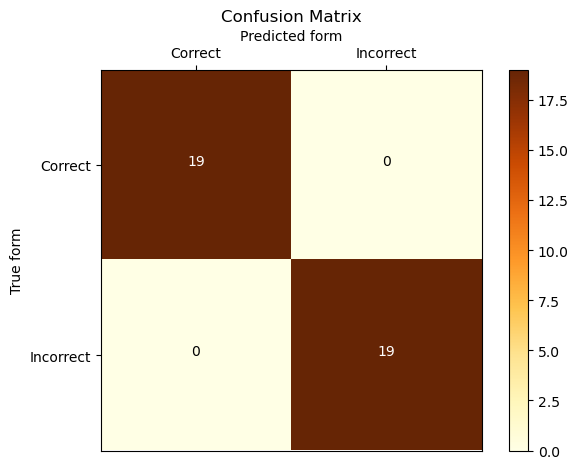

In [52]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Correct', 'Incorrect'])

## Bicep Curl Decision Tree Parameters

[Text(0.5, 0.9166666666666666, 'ay <= -0.137\ngini = 0.5\nsamples = 100.0%\nvalue = [0.503, 0.497]'),
 Text(0.3333333333333333, 0.75, 'gini = 0.0\nsamples = 30.2%\nvalue = [0.0, 1.0]'),
 Text(0.6666666666666666, 0.75, 'az <= 0.383\ngini = 0.402\nsamples = 69.8%\nvalue = [0.721, 0.279]'),
 Text(0.5, 0.5833333333333334, 'gx <= 0.946\ngini = 0.278\nsamples = 60.4%\nvalue = [0.833, 0.167]'),
 Text(0.3333333333333333, 0.4166666666666667, 'az <= -1.121\ngini = 0.156\nsamples = 55.0%\nvalue = [0.915, 0.085]'),
 Text(0.16666666666666666, 0.25, 'gini = 0.0\nsamples = 2.7%\nvalue = [0.0, 1.0]'),
 Text(0.5, 0.25, 'gx <= -0.714\ngini = 0.074\nsamples = 52.3%\nvalue = [0.962, 0.038]'),
 Text(0.3333333333333333, 0.08333333333333333, 'gini = 0.0\nsamples = 2.0%\nvalue = [0.0, 1.0]'),
 Text(0.6666666666666666, 0.08333333333333333, 'gini = 0.0\nsamples = 50.3%\nvalue = [1.0, 0.0]'),
 Text(0.6666666666666666, 0.4166666666666667, 'gini = 0.0\nsamples = 5.4%\nvalue = [0.0, 1.0]'),
 Text(0.8333333333333334

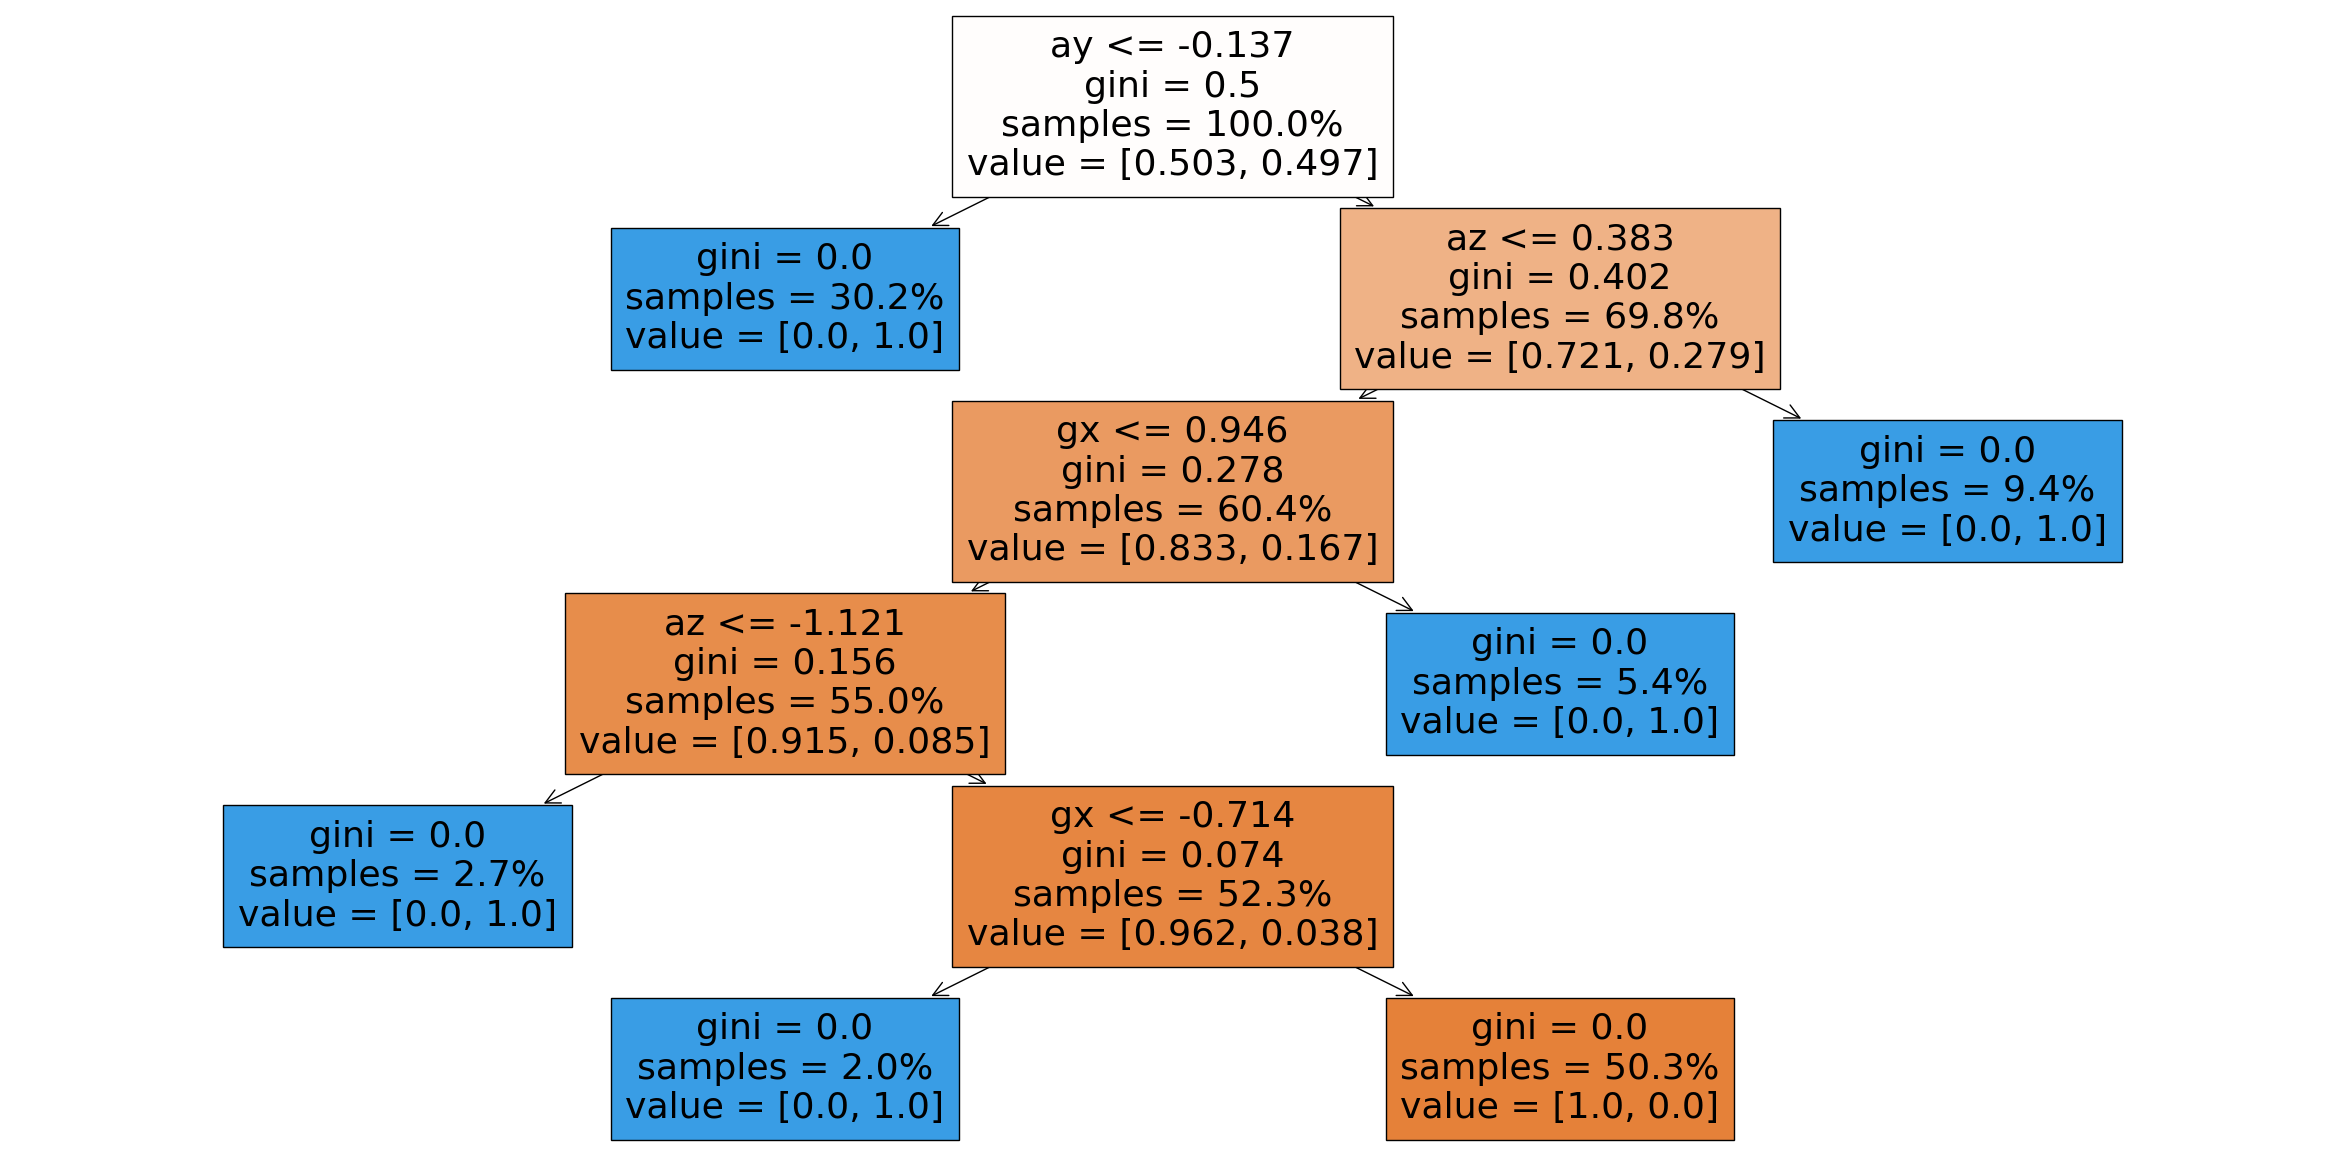

In [53]:
plt.figure(figsize = (30,15)) 
#Note that we have to pass the feature names into the plotting function to get the actual names
#We pass the column names through the pipeline in case any feature augmentation was made
#For example, a categorical feature will be split into multiple features with one hot encoding
#and this way assigns a name to each column based on the feature value and the original feature name
tree.plot_tree(clf,max_depth=5, proportion=True,feature_names=feature_names, filled=True)

In [54]:
from sklearn.tree import export_text
r = export_text(clf, feature_names=feature_names)
print(r)

|--- ay <= -0.14
|   |--- class: 1
|--- ay >  -0.14
|   |--- az <= 0.38
|   |   |--- gx <= 0.95
|   |   |   |--- az <= -1.12
|   |   |   |   |--- class: 1
|   |   |   |--- az >  -1.12
|   |   |   |   |--- gx <= -0.71
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- gx >  -0.71
|   |   |   |   |   |--- class: 0
|   |   |--- gx >  0.95
|   |   |   |--- class: 1
|   |--- az >  0.38
|   |   |--- class: 1



### Bicep Curls Feature Importance

<Axes: >

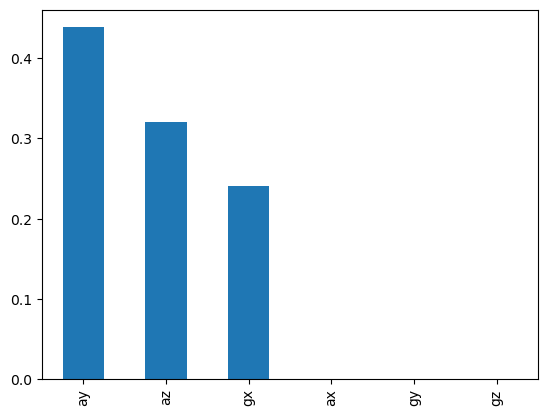

In [55]:
imp_pd = pd.Series(data = clf.feature_importances_ ,index = feature_names)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

### Lateral Raises Data Procesing

In [ ]:
#Preprocess Data

#Load Data
data = pd.read_csv('ml_data/lateral.csv')

#Transform target feature into numerical
le = LabelEncoder() 
data['quality'] = le.fit_transform(data['quality'])

#Split target and data
y = data["quality"]
x = data.drop(["quality"],axis = 1)

#Train test split
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.2, stratify= y, random_state=0)

#Standardize data
#Since all features are real-valued, we only have one pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

#Transform raw data 
train = pipeline.fit_transform(train_raw)
test = pipeline.transform(test_raw) #Note that there is no fit calls

#Names of Features after Pipeline
feature_names = list(pipeline.get_feature_names_out(list(x.columns)))

In [57]:
target.value_counts()

quality
0    105
1     83
Name: count, dtype: int64

In [58]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
quality
0    26
1    21
Name: count, dtype: int64
Baseline Accuraccy of using Majority Class:  0.5531914893617021


In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.978723
Confusion Matrix: 
 [[26  0]
 [ 1 20]]


/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

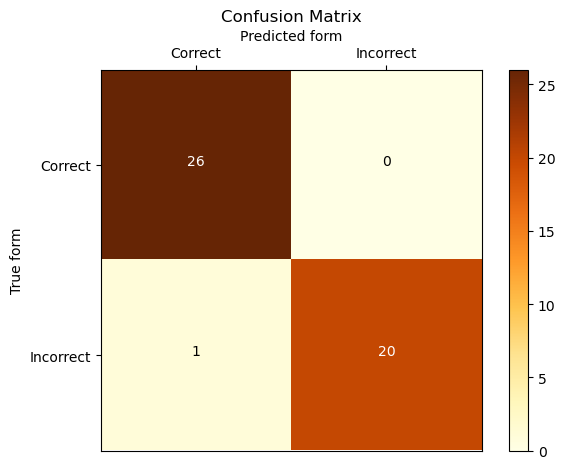

In [61]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Correct', 'Incorrect'])

## Lateral Raises Decision Tree Parameters

[Text(0.25, 0.9375, 'ay <= -0.318\ngini = 0.493\nsamples = 100.0%\nvalue = [0.559, 0.441]'),
 Text(0.125, 0.8125, 'gini = 0.0\nsamples = 28.7%\nvalue = [0.0, 1.0]'),
 Text(0.375, 0.8125, 'gz <= -0.591\ngini = 0.339\nsamples = 71.3%\nvalue = [0.784, 0.216]'),
 Text(0.25, 0.6875, 'gini = 0.0\nsamples = 5.9%\nvalue = [0.0, 1.0]'),
 Text(0.5, 0.6875, 'gz <= 0.411\ngini = 0.25\nsamples = 65.4%\nvalue = [0.854, 0.146]'),
 Text(0.375, 0.5625, 'gy <= -1.564\ngini = 0.145\nsamples = 60.6%\nvalue = [0.921, 0.079]'),
 Text(0.25, 0.4375, 'gini = 0.0\nsamples = 2.1%\nvalue = [0.0, 1.0]'),
 Text(0.5, 0.4375, 'ax <= -0.809\ngini = 0.087\nsamples = 58.5%\nvalue = [0.955, 0.045]'),
 Text(0.25, 0.3125, 'gy <= -0.009\ngini = 0.494\nsamples = 4.8%\nvalue = [0.556, 0.444]'),
 Text(0.125, 0.1875, 'gini = 0.0\nsamples = 2.7%\nvalue = [1.0, 0.0]'),
 Text(0.375, 0.1875, 'gini = 0.0\nsamples = 2.1%\nvalue = [0.0, 1.0]'),
 Text(0.75, 0.3125, 'az <= -0.945\ngini = 0.02\nsamples = 53.7%\nvalue = [0.99, 0.01]'),
 T

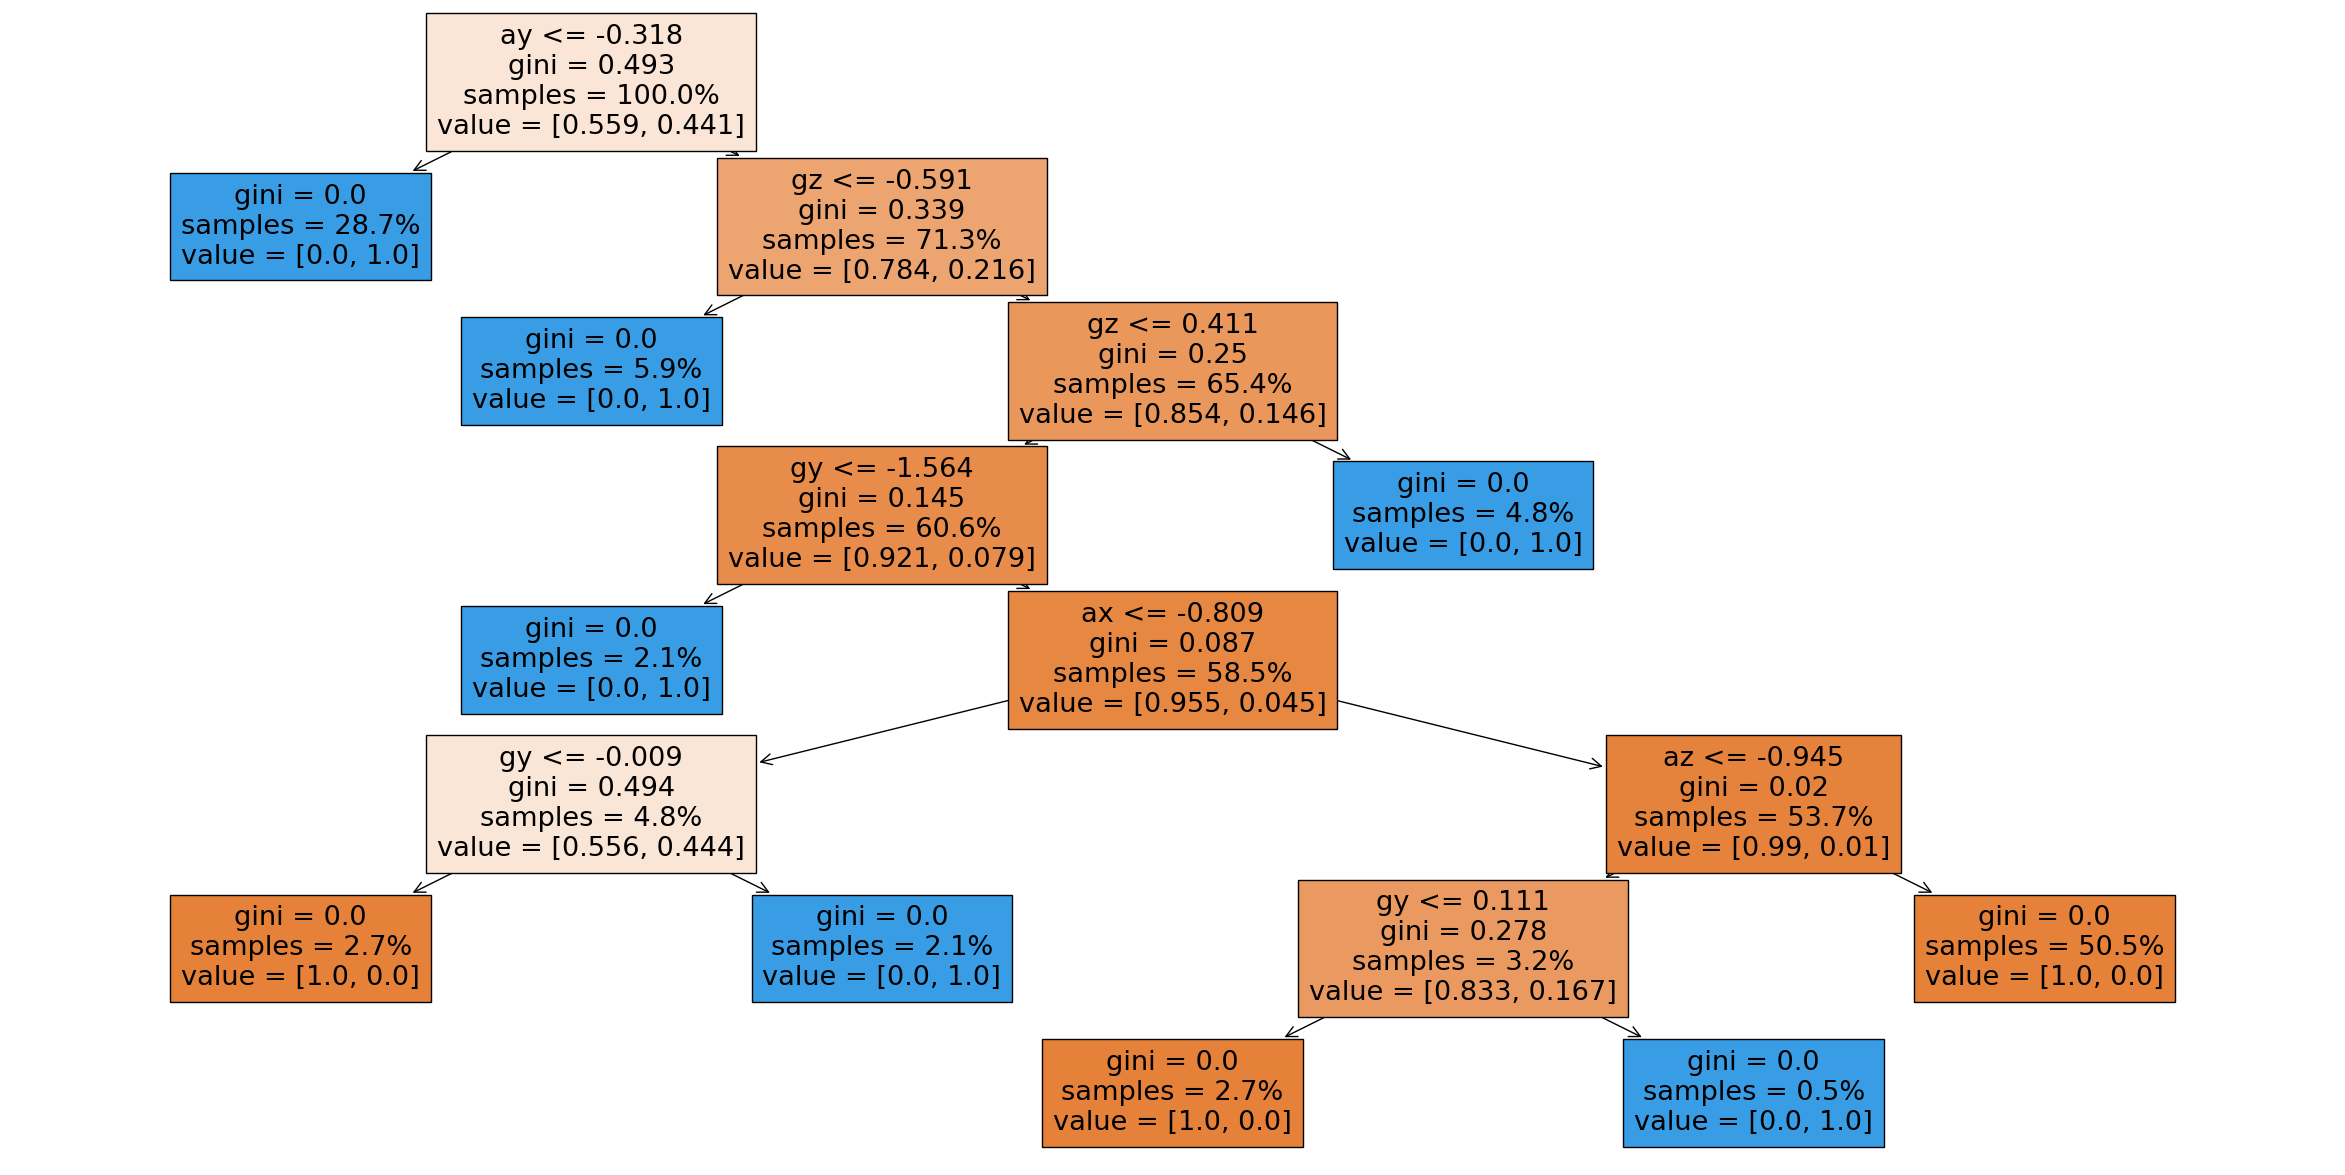

In [64]:
plt.figure(figsize = (30,15)) 
#Note that we have to pass the feature names into the plotting function to get the actual names
#We pass the column names through the pipeline in case any feature augmentation was made
#For example, a categorical feature will be split into multiple features with one hot encoding
#and this way assigns a name to each column based on the feature value and the original feature name
tree.plot_tree(clf,max_depth=7, proportion=True,feature_names=feature_names, filled=True)

In [65]:
from sklearn.tree import export_text
r = export_text(clf, feature_names=feature_names)
print(r)

|--- ay <= -0.32
|   |--- class: 1
|--- ay >  -0.32
|   |--- gz <= -0.59
|   |   |--- class: 1
|   |--- gz >  -0.59
|   |   |--- gz <= 0.41
|   |   |   |--- gy <= -1.56
|   |   |   |   |--- class: 1
|   |   |   |--- gy >  -1.56
|   |   |   |   |--- ax <= -0.81
|   |   |   |   |   |--- gy <= -0.01
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- gy >  -0.01
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- ax >  -0.81
|   |   |   |   |   |--- az <= -0.95
|   |   |   |   |   |   |--- gy <= 0.11
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- gy >  0.11
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- az >  -0.95
|   |   |   |   |   |   |--- class: 0
|   |   |--- gz >  0.41
|   |   |   |--- class: 1



### Lateral Raises Feature Importance

<Axes: >

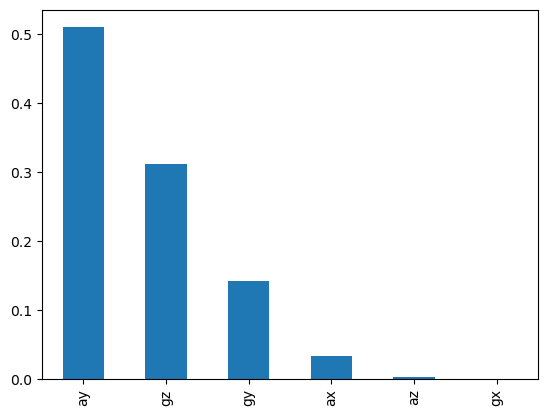

In [66]:
imp_pd = pd.Series(data = clf.feature_importances_ ,index = feature_names)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

### Bent-over Rows Data Processing

In [ ]:
#Preprocess Data

#Load Data
data = pd.read_csv('ml_data/row.csv')

#Transform target feature into numerical
le = LabelEncoder() 
data['quality'] = le.fit_transform(data['quality'])

#Split target and data
y = data["quality"]
x = data.drop(["quality"],axis = 1)

#Train test split
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.2, stratify= y, random_state=0)

#Standardize data
#Since all features are real-valued, we only have one pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

#Transform raw data 
train = pipeline.fit_transform(train_raw)
test = pipeline.transform(test_raw) #Note that there is no fit calls

#Names of Features after Pipeline
feature_names = list(pipeline.get_feature_names_out(list(x.columns)))

In [68]:
target.value_counts()

quality
1    106
0     50
Name: count, dtype: int64

In [69]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
quality
1    27
0    12
Name: count, dtype: int64
Baseline Accuraccy of using Majority Class:  0.6923076923076923


In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    1.000000
Confusion Matrix: 
 [[12  0]
 [ 0 27]]


/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/philipdo/anaconda3/envs/default/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

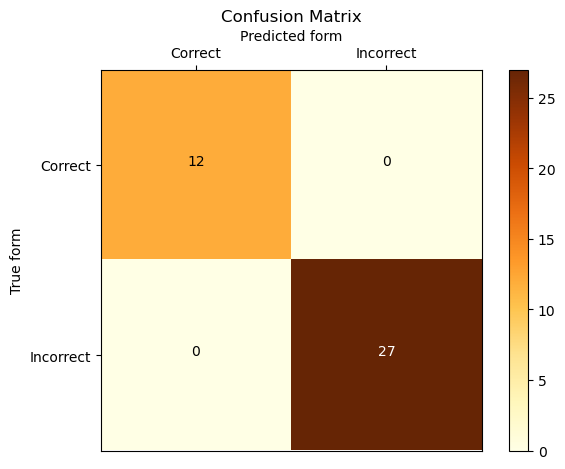

In [72]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Correct', 'Incorrect'])

## Bent-over Rows Decision Tree Parameters

[Text(0.5, 0.9, 'gy <= -0.104\ngini = 0.436\nsamples = 100.0%\nvalue = [0.321, 0.679]'),
 Text(0.3333333333333333, 0.7, 'gini = 0.0\nsamples = 41.7%\nvalue = [0.0, 1.0]'),
 Text(0.6666666666666666, 0.7, 'ay <= 0.234\ngini = 0.495\nsamples = 58.3%\nvalue = [0.549, 0.451]'),
 Text(0.5, 0.5, 'gy <= 1.01\ngini = 0.312\nsamples = 39.7%\nvalue = [0.806, 0.194]'),
 Text(0.3333333333333333, 0.3, 'az <= 0.601\ngini = 0.107\nsamples = 34.0%\nvalue = [0.943, 0.057]'),
 Text(0.16666666666666666, 0.1, 'gini = 0.0\nsamples = 32.1%\nvalue = [1.0, 0.0]'),
 Text(0.5, 0.1, 'gini = 0.0\nsamples = 1.9%\nvalue = [0.0, 1.0]'),
 Text(0.6666666666666666, 0.3, 'gini = 0.0\nsamples = 5.8%\nvalue = [0.0, 1.0]'),
 Text(0.8333333333333334, 0.5, 'gini = 0.0\nsamples = 18.6%\nvalue = [0.0, 1.0]')]

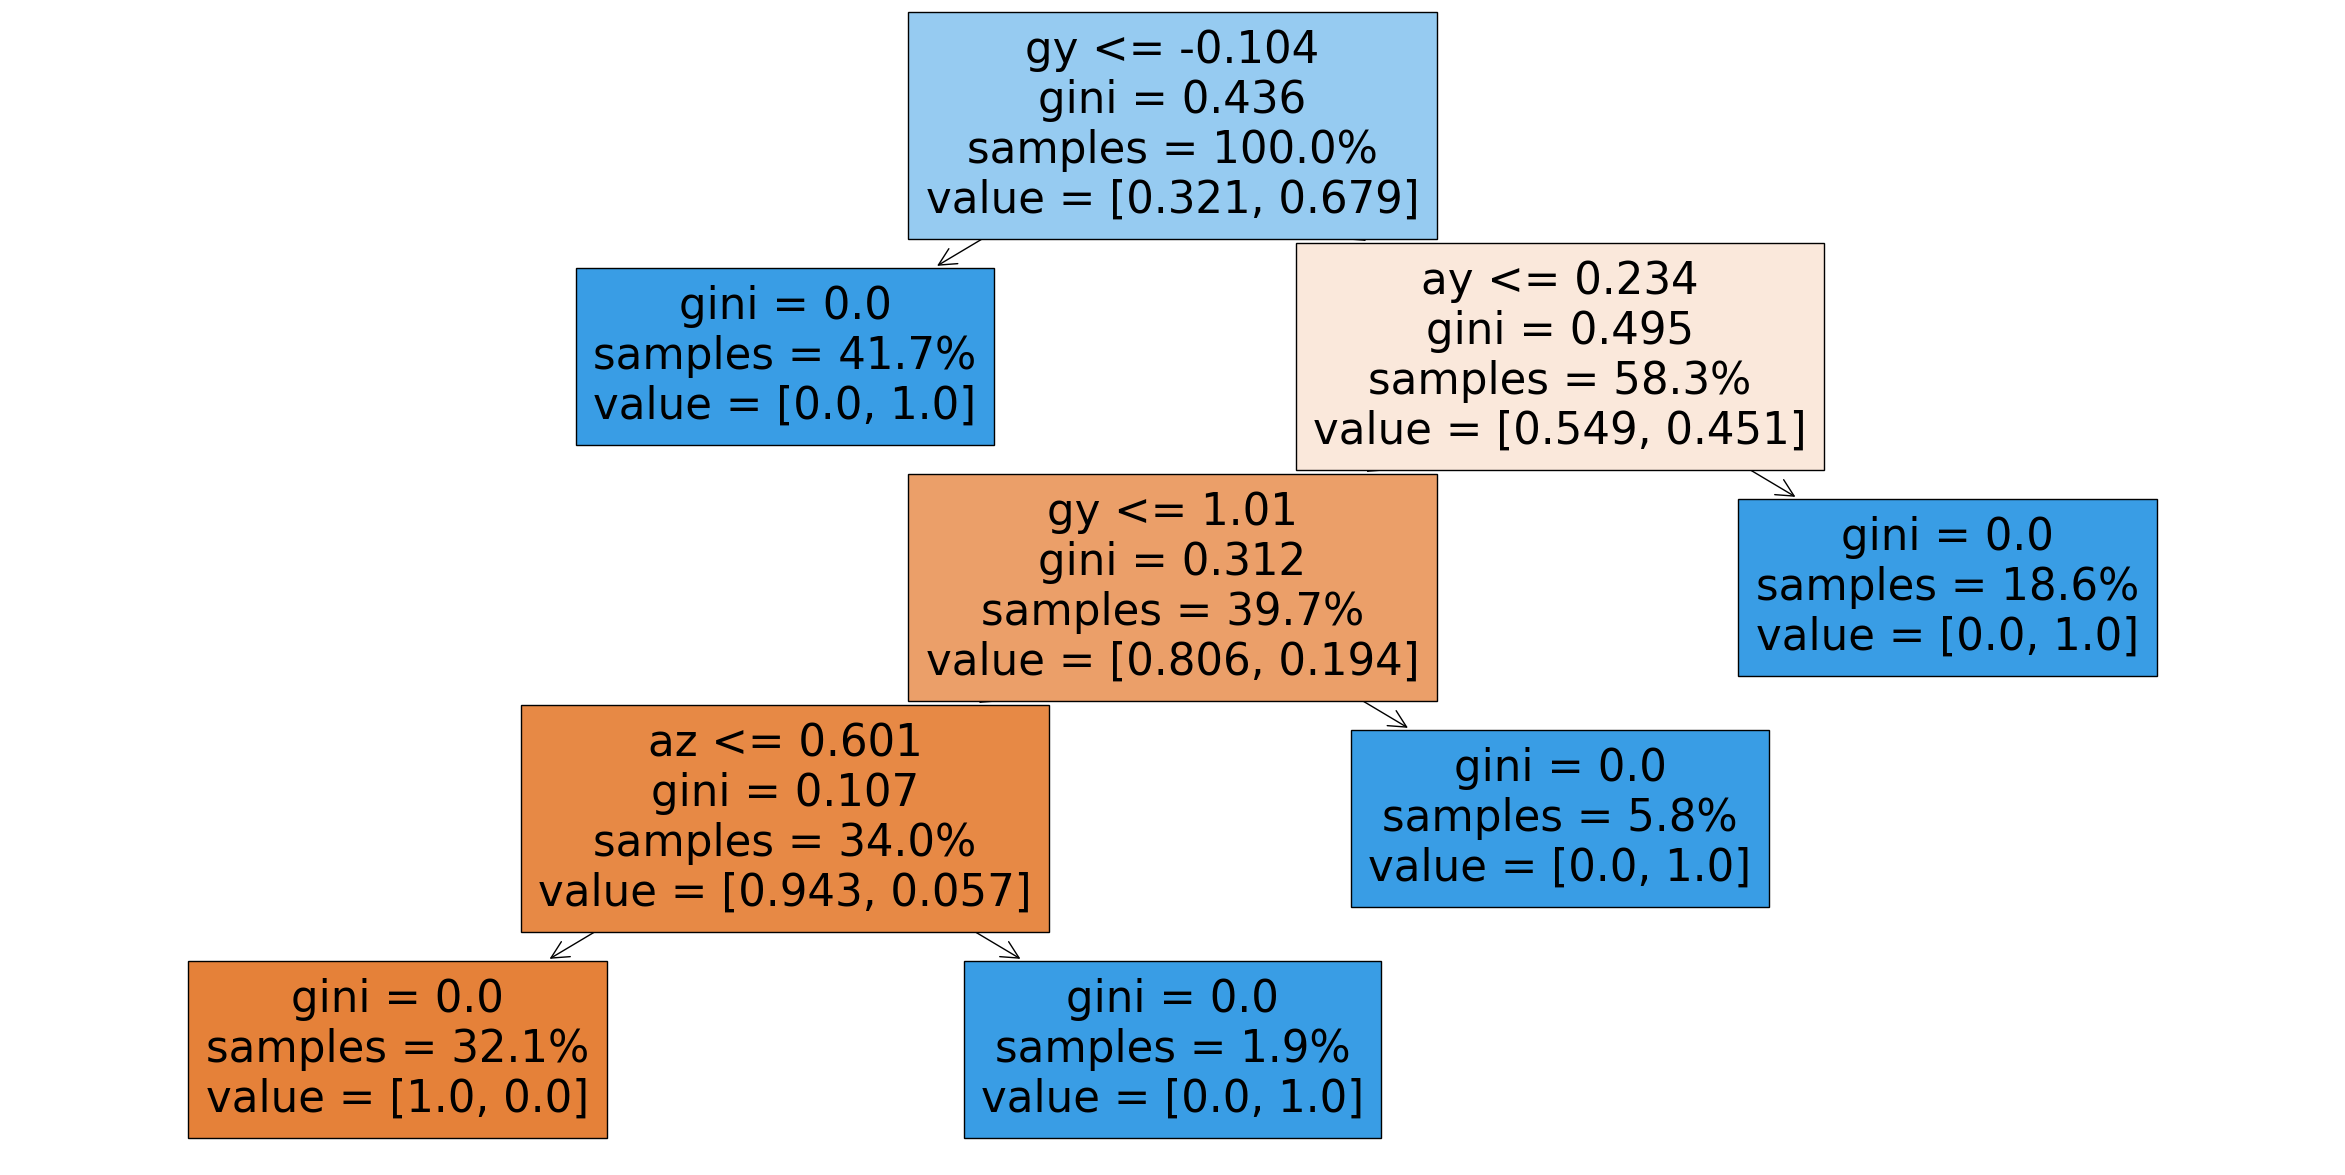

In [73]:
plt.figure(figsize = (30,15)) 
#Note that we have to pass the feature names into the plotting function to get the actual names
#We pass the column names through the pipeline in case any feature augmentation was made
#For example, a categorical feature will be split into multiple features with one hot encoding
#and this way assigns a name to each column based on the feature value and the original feature name
tree.plot_tree(clf,max_depth=5, proportion=True,feature_names=feature_names, filled=True)

### Bent-over Rows Feature Importance